## Постановка Задачи

Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать [общую продолжительность поездки такси в Нью-Йорке](https://www.kaggle.com/competitions/nyc-taxi-trip-duration/overview). 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

### Знакомство с Данными
### Базовый Анализ и Расширение Данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
import numpy as np
import pandas as pd

#import the library for visualization
from matplotlib import pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

Прочитаем наш файл с исходными данными:

In [2]:
taxi_data = pd.read_csv('data/train.csv')

In [3]:
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
print(f'Train data shape: {taxi_data.shape}')

Train data shape: (1458644, 11)


In [5]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах

Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

##### **Задание 2.1**
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [6]:
#convert object to datetime (year-month-day-hour-minute-second)
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

In [7]:
#find the time limits
print(min(taxi_data['pickup_datetime']), max(taxi_data['pickup_datetime']), sep='\n')

2016-01-01 00:00:17
2016-06-30 23:59:39


##### **Задание 2.2**
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [8]:
#check for null values
taxi_data.isnull().sum()[taxi_data.isnull().sum() > 0]

Series([], dtype: int64)

##### **Задание 2.3**
Посмотрим на статистические характеристики некоторых признаков.

а) Сколько уникальных таксопарков присутствует в данных?

In [9]:
print(f"number of unique vendors: {taxi_data['vendor_id'].nunique()}")

number of unique vendors: 2


In [10]:
taxi_data['vendor_id'].value_counts()

vendor_id
2    780302
1    678342
Name: count, dtype: int64

б) Каково максимальное количество пассажиров?

In [11]:
print(f"maximum number of passengers: {max(taxi_data['passenger_count'])}")

maximum number of passengers: 9


в) Чему равна средняя и медианная длительность поездки?

In [12]:
print(f"average trip duration: {round(taxi_data['trip_duration'].mean(), 0)}, \
    median trip duration: {round(taxi_data['trip_duration'].median(), 0)}")

average trip duration: 959.0,     median trip duration: 662.0


г) Чему равно минимальное и максимальное время поездки (в секундах)?

In [13]:
print(f"min trip duration: {min(taxi_data['trip_duration'])}, max trip duration: {max(taxi_data['trip_duration'])}")

min trip duration: 1, max trip duration: 3526282


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


##### **Задание 2.4**
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число), в который был включен счетчик.

In [14]:
#write a function to create datetime features
def add_datetime_features(data, feature):
    #create a feature for date
    data['pickup_date'] = pd.to_datetime(data[feature]).dt.date
    #create a feature for hour
    data['pickup_hour'] = pd.to_datetime(data[feature]).dt.hour
    #create a feature for day of the week
    data['pickup_day_of_week'] = pd.to_datetime(data[feature]).dt.day_name()
    
    return data

#apply the function
add_datetime_features(taxi_data, feature='pickup_datetime')

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,Friday
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,Sunday
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,6,Friday
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,15,Tuesday


а) Сколько поездок было совершено в субботу?

In [15]:
#find the number of trips made on Saturday
taxi_data[taxi_data['pickup_day_of_week'] =='Saturday']['id'].count()

220868

б) Сколько поездок в среднем совершается в день?

In [16]:
#find the average number of trips made per day
round(taxi_data.groupby(by='pickup_date')['pickup_date'].count().mean(), 0)

8015.0

От того, является ли день праздничным, часто зависит ситуация на дорогах. Большое количество автомобилей создаёт пробки и потенциально увеличивает длительность совершаемой на такси поездки.

##### **Задание 2.5**
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет).

--> exception errors, changed the purpose of the function

In [17]:
#import and read the new data set
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')
holiday_data.head(3)

,day,date,holiday
0,Friday,2016-01-01,New Years Day
1,Monday,2016-01-18,Martin Luther King Jr. Day
2,Friday,2016-02-12,Lincoln's Birthday


In [18]:
#convert to datetime
taxi_data['pickup_date'] = pd.to_datetime(taxi_data['pickup_date'])
holiday_data['date'] = pd.to_datetime(holiday_data['date'])

In [19]:
#merge tables
train_data = pd.merge(taxi_data, holiday_data,
                      left_on='pickup_date',
                      right_on='date',
                      how='left')

In [20]:
#fill the null values
train_data['holiday'] = train_data['holiday'].fillna(0)

In [21]:
#delete uninformative features
train_data = train_data.drop(['day', 'date'],
                             axis=1,
                             errors='ignore')

In [22]:
#write a function to differentiate between normal days and holidays
def add_holiday_features(x):
    #if the value is set to 0, return the original value
    if x['holiday'] == 0:
        return x['holiday']
    #for all other conditions
    else:
        return 1

In [23]:
#create a new column by applying the function
train_data['pickup_holiday'] = train_data.apply(add_holiday_features, axis=1)

In [24]:
#confirm the change
train_data['pickup_holiday'].value_counts()

pickup_holiday
0    1407522
1      51122
Name: count, dtype: int64

Чему равна медианная длительность поездки на такси в праздничные дни?

In [25]:
print(f"median trip duration during the holidays: {train_data[train_data['pickup_holiday'] == 1]['trip_duration'].median()}")

median trip duration during the holidays: 585.0


##### **Задание 2.6**
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

Проблема заключается в том, что, так как в наших данных содержится информация о более чем одном миллионе поездок, подгрузка данных с помощью API и их предобработка может занять несколько часов, а при слабом интернет-соединении — и дней. Поэтому мы заранее подготовили выгрузку данных из OSRM API для каждой поездки из тренировочной и тестовой выборок нашего набора данных.

In [26]:
#import the new data set
osrm = pd.read_csv('data/osrm_data_train.csv')


        id — идентификатор поездки;
        total_distance — кратчайшее дорожное расстояние (в метрах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
        total_travel_time — наименьшее время поездки (в секундах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
        number_of_steps — количество дискретных шагов, которые должен выполнить водитель (поворот налево/поворот направо/ехать прямо и т. д.).


In [27]:
#read the data set
osrm.head(2)

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id2875421,Columbus Circle,East 65th Street,2009.1,164.9,5,Columbus Circle|Central Park West|65th Street ...,0|576.4|885.6|547.1|0,0|61.1|60.1|43.7|0,depart|rotary|turn|new name|arrive,left|straight|right|straight|arrive,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,2nd Avenue,Washington Square West,2513.2,332.0,6,2nd Avenue|East 13th Street|5th Avenue|Washing...,877.3|836.5|496.1|164.2|139.1|0,111.7|109|69.9|25.8|15.6|0,depart|turn|turn|end of road|continue|arrive,none|right|left|right|left|arrive,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."


In [28]:
#write a function to merge two tables and select a number of features
def add_osrm_features(df_1, df_2):
    #slice the data set to keep the necessary features
    new_df = df_2[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
    
    #merge the tables
    merged = pd.merge(df_1, new_df,
                      left_on='id',
                      right_on='id',
                      how='left')
    
    return merged

In [29]:
#apply the function
train_data = add_osrm_features(train_data, osrm)

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника.

In [30]:
#set the masks
median_trip_duration = train_data['trip_duration'].median()
median_total_travel_time = train_data['total_travel_time'].median()

#find the difference between median trip duration and median total travel time
print(median_trip_duration, median_total_travel_time, sep=', ')
print(f"difference in seconds: {round(median_trip_duration - median_total_travel_time, 0)}")

662.0, 289.5
difference in seconds: 372.0


б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [31]:
#check for null values
train_data.isnull().sum()[train_data.isnull().sum() > 0]

total_distance       1
total_travel_time    1
number_of_steps      1
dtype: int64

С помощью географических характеристик можно извлечь ещё немного информации. Если рассматривать Землю как сферу, то, зная широту и долготу начальной и конечной точек маршрута, можно вычислить географическое расстояние между точками на сфере, а также узнать направление движения автомобиля.

Введём в наш анализ расстояние по формуле гаверсинуса. 

Данная формула определяет кратчайшее расстояние между двумя точками на сфере, если известны широта и долгота каждой из точек. Геометрически это длина кратчайшей дуги, связывающей точки на сфере.

In [32]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    #convert angles to radians
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    
    #earth's radius in km
    earth_radius = 6371 
    
    #calculate the shortest distance using harverine distance
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * earth_radius * np.arcsin(np.sqrt(d))
    
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    #convert angles to radians
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    
    #calculate the direction angle alpha by the bearing angle formula
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    
    return alpha

##### **Задание 2.7**
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

In [33]:
#write the function to include haversine distance and angle_direction
def add_geographical_features(x):
    x['haversine_distance'] = x.apply(
        lambda row: get_haversine_distance(
            row['pickup_latitude'], row['pickup_longitude'],
            row['dropoff_latitude'], row['dropoff_longitude'],
            ), 
        axis=1
        )

    x['direction'] = x.apply(
        lambda row: get_angle_direction(
            row['pickup_latitude'], row['pickup_longitude'],
            row['dropoff_latitude'], row['dropoff_longitude'],
            ), 
        axis=1
        )
    
    return x

In [34]:
#apply the function
train_data = add_geographical_features(train_data)

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)?

In [35]:
print(train_data['haversine_distance'].median(), train_data['haversine_distance'].median().round(2), sep=', ')

2.0937171329266784, 2.09


##### **Задание 2.8**

Следующая методика манипуляций с географическими данными — это применение кластеризации по географическим координатам. Идея заключается в том, чтобы сгруппировать все поездки в зависимости от координат начала и конца поездки с помощью методов кластеризации, тем самым добавив информацию о районах, в которых находятся точки старта и конца поездки.

Гипотеза состоит в том, что длительность поездки будет зависеть от того, к какому географическому кластеру будет принадлежать поездка.

Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

In [36]:
#write a function to add a cluster
def add_cluster_features(x):
    #create a training sample from the geographic coordinates of all points
    coords = x[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].values

    kmeans = cluster.KMeans(n_clusters=10,
                        random_state=42)
    
    #train the clustering algorithm
    kmeans.fit(coords)

    #create the new predictive feature
    x['geo_cluster'] = kmeans.predict(coords)

    return x

In [37]:
#apply the function
train_data = add_cluster_features(train_data)

Сколько поездок содержится в наименьшем по размеру географическом кластере?

In [38]:
train_data.groupby(by='geo_cluster')['geo_cluster'].count().nsmallest(1)

geo_cluster
1    2
Name: geo_cluster, dtype: int64

##### **Задание 2.9**
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

In [39]:
#import the new data set
weather_data = pd.read_csv('data/weather_data.csv')

In [40]:
#read the data set
weather_data.head(2)

,time,temperature,windchill,heat index,humidity,pressure,dew Point,visibility,wind dir,wind speed,gust speed,precip,events,conditions,date,hour
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,NaN,Overcast,2015-12-31,2
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,NaN,Overcast,2015-12-31,3


In [41]:
#check the details of a feature
weather_data['events'].value_counts()

events
Rain    379
Snow     74
Fog       2
Name: count, dtype: int64

In [42]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8787 entries, 0 to 8786
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         8787 non-null   object 
 1   temperature  8787 non-null   float64
 2   windchill    2295 non-null   float64
 3   heat index   815 non-null    float64
 4   humidity     8787 non-null   float64
 5   pressure     8556 non-null   float64
 6   dew Point    8787 non-null   float64
 7   visibility   8787 non-null   float64
 8   wind dir     8787 non-null   object 
 9   wind speed   8787 non-null   float64
 10  gust speed   8787 non-null   float64
 11  precip       8787 non-null   float64
 12  events       455 non-null    object 
 13  conditions   8787 non-null   object 
 14  date         8787 non-null   object 
 15  hour         8787 non-null   int64  
dtypes: float64(10), int64(1), object(5)
memory usage: 1.1+ MB


In [43]:
#write a function to merge two tables and select a number of features
def add_weather_features(df_1, df_2):
    #slice the data set to keep the necessary features
    new_df = df_2[['temperature', 'visibility', 'wind speed', 'precip', 'events', 'date', 'hour']]
    
    #convert to datetime
    new_df['date'] = pd.to_datetime(new_df['date'])

    #merge the tables
    merged = pd.merge(df_1, new_df,
                      left_on=['pickup_date', 'pickup_hour'],
                      right_on=['date', 'hour'],
                      how='left')
    
    return merged

In [44]:
#apply the function
train_data = add_weather_features(train_data, weather_data)

/var/folders/0j/pqz07rqd22q5j3qyrrpztqnr0000gn/T/ipykernel_4446/433906071.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['date'] = pd.to_datetime(new_df['date'])


а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки.

In [45]:
train_data['events'].value_counts()

events
Rain    58300
Snow    13126
Fog         1
Name: count, dtype: int64

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.

In [46]:
(train_data['events'].count() / train_data['id'].count()) * 100

4.89680826850143

Теперь, когда мы расширили датасет новыми признаками, нам необходимо немного его подчистить. О чём речь?

        В результате добавления новой информации у нас появились пропущенные значения в данных.
        Благодаря новым добавленным признакам мы сможем более детально изучить поездки с аномальной длительностью.

*data[col] = data[col].fillna(data.groupby('pickup_date')[col].transform('median')*

##### **Задание 2.10**
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам.

In [47]:
#write a function to fill in blanks
def fill_null_weather_data(x):    
    #fill the null values - for weather features
    x[['temperature', 'visibility', 'wind speed', 'precip']] = x[['temperature', 'visibility', 'wind speed', 'precip']].fillna(
            x.groupby('pickup_date')[['temperature', 'visibility', 'wind speed', 'precip']].transform('median'))
    
    #create the features for osrm
    osrm_feat = {
        'total_distance': x['total_distance'].median(),
        'total_travel_time': x['total_travel_time'].median(),
        'number_of_steps': x['number_of_steps'].median(),
        'events': 'None'
    }
    
    #fill the null values with dict
    x = x.fillna(osrm_feat)
    
    return x

In [48]:
#apply the function
train_data = fill_null_weather_data(train_data)

In [49]:
#check for null values
train_data.isnull().sum()[train_data.isnull().sum() > 0]

date    12032
hour    12032
dtype: int64

Чему равна медиана в столбце temperature после заполнения пропусков?

In [50]:
train_data['temperature'].median()

11.1

В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


In [51]:
#find the average speed
avg_speed = train_data['total_distance'] / train_data['trip_duration'] * 3.6

In [52]:
#create a scatter graph
fig = px.scatter(train_data,
                 x=avg_speed.index,
                 y=avg_speed,
                 title='Average Speed Distribution'
)

#set the title of the axis
fig.update_layout(
   height=500,
   width=700,
   xaxis_title_text='Index',
   yaxis_title_text='Average speed',
   showlegend=False
)

#fig.show()

#export the graph
fig.write_html('graphs/0.1_scatter_average_speed.html')

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


##### **Задание 2.11**
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

In [53]:
#find records with a trip taking over 24 hours
train_data[train_data['trip_duration'] > (24*60*60)]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,date,hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,...,20.148664,-44.316302,2,-2.8,16.1,5.6,0.0,None,NaT,NaN
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,...,5.982487,-62.618646,3,-14.4,16.1,25.9,0.0,None,2016-02-13,22.0
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,...,1.635128,-174.969924,9,-11.1,16.1,7.4,0.0,None,2016-01-05,6.0
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,...,19.900661,-55.358997,2,-14.4,16.1,25.9,0.0,None,2016-02-13,22.0


In [54]:
#create a mask
over_a_day = train_data['trip_duration'] > (24*60*60)

#delete the outliers
train_data = train_data[~over_a_day]

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

б) Сколько выбросов по признаку скорости вам удалось найти?

In [55]:
#add the average speed to the data set
train_data['mean_speed'] = train_data['total_distance'] / train_data['trip_duration'] * 3.6

In [56]:
train_data[train_data['mean_speed'] > 300]['id'].count()

407

In [57]:
#create a mask
over_speed_limit = train_data['mean_speed'] > 300

#delete the outliers
train_data = train_data[~over_speed_limit]

In [58]:
#delete uninformative features
train_data = train_data.drop(['date', 'hour', 'holiday'],
                             axis=1,
                             errors='ignore')

In [59]:
#rename the columns
train_data = train_data.rename(columns={'wind speed': 'wind_speed',
                                                               
})

In [60]:
#check for null values
train_data.isnull().sum()[train_data.isnull().sum() > 0]

Series([], dtype: int64)

In [61]:
#convert to datetime
train_data['dropoff_datetime'] = pd.to_datetime(train_data['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

In [62]:
#convert the data types to reduce memory space
train_data['vendor_id'] = train_data['vendor_id'].to_numpy('int8')
train_data['passenger_count'] = train_data['passenger_count'].to_numpy('int8')
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].astype('string')
train_data['trip_duration'] = train_data['trip_duration'].to_numpy('int32')
train_data['pickup_hour'] = train_data['pickup_hour'].to_numpy('int8')
train_data['pickup_day_of_week'] = train_data['pickup_day_of_week'].astype('string')
train_data['pickup_holiday'] = train_data['pickup_holiday'].to_numpy('int8')
train_data['number_of_steps'] = train_data['number_of_steps'].to_numpy('int8')
train_data['geo_cluster'] = train_data['geo_cluster'].to_numpy('int8')
train_data['events'] = train_data['events'].astype('string')

In [63]:
#convert the data types to reduce memory space
train_data['pickup_longitude'] = train_data['pickup_longitude'].to_numpy('float32')
train_data['pickup_latitude'] = train_data['pickup_latitude'].to_numpy('float32')
train_data['dropoff_longitude'] = train_data['dropoff_longitude'].to_numpy('float32')
train_data['dropoff_latitude'] = train_data['dropoff_latitude'].to_numpy('float32')
train_data['total_distance'] = train_data['total_distance'].to_numpy('float32')
train_data['total_travel_time'] = train_data['total_travel_time'].to_numpy('float32')
train_data['haversine_distance'] = train_data['haversine_distance'].to_numpy('float32')
train_data['direction'] = train_data['direction'].to_numpy('float32')
train_data['temperature'] = train_data['temperature'].to_numpy('float32')
train_data['visibility'] = train_data['visibility'].to_numpy('float32')
train_data['wind_speed'] = train_data['wind_speed'].to_numpy('float32')
train_data['precip'] = train_data['precip'].to_numpy('float32')
train_data['mean_speed'] = train_data['mean_speed'].to_numpy('float32')

### Разведывательный Анализ Данных

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [64]:
#logarithmize trip duration
train_data['trip_duration_log'] = np.log(train_data['trip_duration']+1)

#convert the data types to reduce memory space
train_data['trip_duration_log'] = train_data['trip_duration_log'].to_numpy('float32')

##### **Задание 3.1**
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? 
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

In [65]:
#create side by side histogram and boxplot under feature 'trip_duration'
#set primary chart: histogram
fig = px.histogram(
    data_frame=train_data,
    x='trip_duration',
    #set secondary chart: boxplot
    marginal='box',
    width=1100,
    height=600,
    color_discrete_sequence=['darkcyan'],
    title='Distribution of Trip Duration',
)

#set the title of the y-axis
fig.update_layout(
    xaxis_title='Trip Duration',
    yaxis_title_text='Count',
)

#fig.show()

#export the graph
fig.write_html('graphs/1.1a_histogram_n_boxplot_by_trip_duration.html')

In [66]:
#create side by side histogram and boxplot under feature 'trip_duration_log'
#set primary chart: histogram
fig = px.histogram(
    data_frame=train_data,
    x='trip_duration_log',
    #set secondary chart: boxplot
    marginal='box',
    width=1100,
    height=600,
    color_discrete_sequence=['indianred'],
    title='Distribution of Trip Duration in Logarithmic Scale',
)

#set the title of the y-axis
fig.update_layout(
    xaxis_title='Log Trip Duration',
    yaxis_title_text='Count',
)

#fig.show()

#export the graph
fig.write_html('graphs/1.1b_histogram_n_boxplot_by_trip_duration_log.html')

а) Чему равен вычисленный p-value?

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

In [67]:
from scipy.stats import normaltest

#set the significance level
alpha = 0.05

#execute D'Agostino's K-squared Test
stat, p = normaltest(train_data['trip_duration_log'])

print('stat=%.3f, p=%.3f\n' % (stat, p))

if p > alpha:
    print('normal distribution')
else:
    print('not normal distribution')

stat=138350.467, p=0.000

not normal distribution


##### **Задание 3.2**
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравните два распределения между собой.

In [68]:
#filter by 1st vendor
vendor1_trip_duration = train_data[train_data['vendor_id'] == 1]

#create side by side histogram and boxplot under feature 'trip_duration_log' by vendor
#set primary chart: histogram
fig = px.histogram(
    data_frame=vendor1_trip_duration,
    x='trip_duration_log',
    #set secondary chart: boxplot
    marginal='box',
    width=1100,
    height=600,
    color_discrete_sequence=['olive'],
    title='Distribution of Trip Duration in Logarithmic Scale for the First Vendor',
)

#set the title of the y-axis
fig.update_layout(
    xaxis_title='Log Trip Duration',
    yaxis_title_text='Count',
)

#fig.show()

#export the graph
fig.write_html('graphs/2.1a_histogram_n_boxplot_of_trip_duration_log_by_vendor.html')

In [69]:
#filter by 2nd vendor
vendor2_trip_duration = train_data[train_data['vendor_id'] == 2]

#create side by side histogram and boxplot under feature 'trip_duration_log' by vendor
#set primary chart: histogram
fig = px.histogram(
    data_frame=vendor2_trip_duration,
    x='trip_duration_log',
    #set secondary chart: boxplot
    marginal='box',
    width=1100,
    height=600,
    color_discrete_sequence=['green'],
    title='Distribution of Trip Duration in Logarithmic Scale for the Second Vendor',
)

#set the title of the y-axis
fig.update_layout(
    xaxis_title='Log Trip Duration',
    yaxis_title_text='Count',
)

#fig.show()

#export the graph
fig.write_html('graphs/2.1b_histogram_n_boxplot_of_trip_duration_log_by_vendor.html')

**Вывод**:

Распределения в группах практически не отличаются, признак vendor_id не имеет значения при определении длительности поездки.

##### **Задание 3.3**
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравните два распределения между собой.

In [70]:
#filter by flag=Y
flag_y_trip_duration = train_data[train_data['store_and_fwd_flag'] == 'Y']

#create side by side histogram and boxplot under feature 'trip_duration_log' by flag
#set primary chart: histogram
fig = px.histogram(
    data_frame=flag_y_trip_duration,
    x='trip_duration_log',
    #set secondary chart: boxplot
    marginal='box',
    width=1100,
    height=600,
    color_discrete_sequence=['olive'],
    title='Distribution of Trip Duration in Logarithmic Scale by Successful Messaging to Vendor',
)

#set the title of the y-axis
fig.update_layout(
    xaxis_title='Log Trip Duration',
    yaxis_title_text='Count',
)

#fig.show()

#export the graph
fig.write_html('graphs/3.1a_histogram_n_boxplot_of_trip_duration_log_by_flag.html')

In [71]:
#filter by flag=N
flag_n_trip_duration = train_data[train_data['store_and_fwd_flag'] == 'N']

#create side by side histogram and boxplot under feature 'trip_duration_log' by flag
#set primary chart: histogram
fig = px.histogram(
    data_frame=flag_n_trip_duration,
    x='trip_duration_log',
    #set secondary chart: boxplot
    marginal='box',
    width=1100,
    height=600,
    color_discrete_sequence=['olive'],
    title='Distribution of Trip Duration in Logarithmic Scale by Unsuccessful Messaging to Vendor',
)

#set the title of the y-axis
fig.update_layout(
    xaxis_title='Log Trip Duration',
    yaxis_title_text='Count',
)

#fig.show()

#export the graph
fig.write_html('graphs/3.1b_histogram_n_boxplot_of_trip_duration_log_by_flag.html')

**Вывод**:

Распределения в группах значительно отличаются, признак store_and_fwd_flag имеет значение при определении длительности поездки.

Если внимательно присмотреться к распределению длительности поездок в зависимости от признака store_and_fwd_flag, становится ясно, что наиболее длительные поездки принадлежат к группе N (не хранить и не пересылать поездку). Таким образом, флаг сохраняется только для кратковременных поездок, а для аномальных многочасовых — не сохраняется.

##### **Задание 3.4**
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

In [72]:
#group by pickup hour
trips_by_hour = train_data.groupby('pickup_hour')['id'].count()

#create a bar chart
fig = px.bar(
    data_frame=trips_by_hour,
    x=trips_by_hour.index,
    y='id',
    color='id',
    width=750,
    height=500,
    color_continuous_scale = 'speed',
    title='Distribution of Trips by Pickup Hour',
)

#set the title of the axis and y-axis limits
fig.update_layout(
    xaxis_title_text='Pickup Hour',
    yaxis_title_text='Number of Trips',
)

#fig.show()

#export the graph
fig.write_html('graphs/4.1_bar_trips_by_hour.html')

а) В какое время суток такси заказывают реже всего?

Заказывают реже всего между 00.00-05.00.

In [73]:
#group by pickup hour
median_trip_duration_by_hour = train_data.groupby('pickup_hour')['trip_duration'].median()

#create a bar chart
fig = px.bar(
    data_frame=median_trip_duration_by_hour,
    x=median_trip_duration_by_hour.index,
    y='trip_duration',
    color='trip_duration',
    width=750,
    height=500,
    color_continuous_scale = 'gray',
    title='Distribution of Trip Duration by Pickup Hour',
)

#set the title of the axis and y-axis limits
fig.update_layout(
    xaxis_title_text='Pickup Hour',
    yaxis_title_text='Trip Duration',
)

#fig.show()

#export the graph
fig.write_html('graphs/4.2_bar_trip_duration_by_hour.html')

б) В какое время суток наблюдается пик медианной длительности поездок?

С 13:00 по 18:00.

##### **Задание 3.5**
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.


In [74]:
#group by pickup day of the week
trips_by_weekday = train_data.groupby('pickup_day_of_week')['id'].count().sort_values()

#create a bar chart
fig = px.bar(
    data_frame=trips_by_weekday,
    x=trips_by_weekday.index,
    y='id',
    color='id',
    width=750,
    height=500,
    color_continuous_scale = 'delta',
    title='Distribution of Trips by Pickup Week Day',
)

#set the title of the axis and y-axis limits
fig.update_layout(
    xaxis_title_text='Pickup Day of the Week',
    yaxis_title_text='Number of Trips',
)

#fig.show()

#export the graph
fig.write_html('graphs/5.1_bar_trips_by_weekday.html')

а) В какой день недели совершается больше всего поездок?

Пятница.

In [75]:
#group by pickup day of the week
median_trip_duration_by_weekday = train_data.groupby('pickup_day_of_week')['trip_duration'].median().sort_values()

#create a bar chart
fig = px.bar(
    data_frame=median_trip_duration_by_weekday,
    x=median_trip_duration_by_weekday.index,
    y='trip_duration',
    color='trip_duration',
    width=750,
    height=500,
    color_continuous_scale = 'edge',
    title='Distribution of Trip Duration by Pickup Week Day',
)

#set the title of the axis and y-axis limits
fig.update_layout(
    xaxis_title_text='Pickup Day of the Week',
    yaxis_title_text='Trip Duration',
)

#fig.show()

#export the graph
fig.write_html('graphs/5.2_bar_trip_duration_by_weekday.html')

б) В какой день недели медианная длительность поездок наименьшая?

Воскресение.

##### **Задание 3.6**
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

In [76]:
#create a pivot chart and group by hour, weekday and (median) trip duration
combine_hour_weekday = train_data.pivot_table(
    values='trip_duration',
    index='pickup_hour',
    columns='pickup_day_of_week',
    aggfunc='median',
)

#visualise the pivot table
fig = px.imshow(combine_hour_weekday.T,
                text_auto=True,
                )

#set characteristics
fig.update_layout(height=500,
                  width=1000,
                  title_text='Trip Duration by Hour and Week Day'
)

#fig.show()

#export the graph
fig.write_html('graphs/6_heatmap_of_trip_duration_by_day_and_hour.html')

##### **Задание 3.7**
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


In [77]:
#create a scatter graph
fig = px.scatter(train_data,
                 x='pickup_longitude',
                 y='pickup_latitude',
                 color='geo_cluster',
                 title='Distribution of Pickup Latitude and Longitude'
)

#set the city longitude border
fig.update_layout(xaxis_range=[-74.03, -73.75])

#set the city latitude border
fig.update_layout(yaxis_range=[40.63, 40.85])

#set the title of the axis
fig.update_layout(
   height=700,
   width=900,
   xaxis_title_text='Pickup Longitude',
   yaxis_title_text='Pickup Latitude',
   showlegend=False
)

#reduce the marker size
fig.update_traces(marker=dict(size=3))

#fig.show()

#export the graph
fig.write_html('graphs/7.1_scatter_pickup_lat_n_lng.html')

In [78]:
#create a scatter graph
fig = px.scatter(train_data,
                 x='dropoff_longitude',
                 y='dropoff_latitude',
                 color='geo_cluster',
                 title='Distribution of Dropoff Latitude and Longitude'
)

#set the city longitude border
fig.update_layout(xaxis_range=[-74.03, -73.75])

#set the city latitude border
fig.update_layout(yaxis_range=[40.63, 40.85])

#set the title of the axis
fig.update_layout(
   height=700,
   width=900,
   xaxis_title_text='Dropoff Longitude',
   yaxis_title_text='Dropoff Latitude',
   showlegend=False
)

#reduce the marker size
fig.update_traces(marker=dict(size=3))

#fig.show()

#export the graph
fig.write_html('graphs/7.2_scatter_dropoff_lat_n_lng.html')

### Отбор и Преобразование Признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [79]:
print(f'Shape of data: {train_data.shape}')
print()
print(f'Features: {train_data.columns}')

Shape of data: (1458233, 28)

Features: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind_speed', 'precip', 'events',
       'mean_speed', 'trip_duration_log'],
      dtype='object')


##### **Задание 4.1**

Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

Уникальным для каждой поездки является её идентификатор — столбец id. Он никак не связан с длительностью поездки и не имеет значения при её прогнозировании.

б) Утечка данных (data leak) - это ситуация, в которой данные используемые для обучения модели, содержат прямую или косвенную информацию о целевой переменной, но эти данные недоступны в реальных условиях.

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

В наших данных утечку создаёт признак dropoff_datetime — зафиксированное время остановки счётчика. Начиная поездку, мы никак не можем точно знать, когда она закончится, ведь мы как раз и пытаемся предсказать время окончания поездки.

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?

In [80]:
#delete uninformative features
train_data = train_data.drop(['id', 'dropoff_datetime', 'mean_speed'],
                             axis=1,
                             errors='ignore')

print(f'New Dimensions: {train_data.shape}')

New Dimensions: (1458233, 25)


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [81]:
#select uninformative features
drop_columns = ['pickup_datetime', 'pickup_date']

#delete uninformative features
train_data = train_data.drop(drop_columns,
                             axis=1,
                             errors='ignore')

print(f'Shape of data:  {train_data.shape}')

Shape of data:  (1458233, 23)


Теперь займёмся кодированием категориальных признаков. В наших данных к категориальным можно отнести следующие признаки:

        vendor_id;
        store_and_fwd_flag;
        pickup_day_of_week;
        geo_cluster;
        events.

##### **Задание 4.2**

Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

In [82]:
#encode the categorical features
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 1 if x == 2 else 0)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 1 if x == 'Y' else 0)

а) Рассчитайте среднее по закодированному столбцу vendor_id.

In [83]:
print(train_data['vendor_id'].mean(), train_data['vendor_id'].mean().round(2), sep=', ')

0.53497486341346, 0.53


б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag.

In [84]:
print(train_data['store_and_fwd_flag'].mean(), train_data['store_and_fwd_flag'].mean().round(3), sep=', ')

0.005514207948935458, 0.006


Следующие три признака (pickup_day_of_week, geo_cluster, events) являются номинальными.  Для них отлично подойдёт однократное кодирование.

##### **Задание 4.3**
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В параметре handle_unknown установите значение 'ignore'. Это позволит коду отработать без ошибок в случае появления в тестовой выборке значений, отсутствующих в обучающей выборке.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Объявляем кодировщик
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [85]:
#select the features to encode
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']

#create the object class
one_hot = preprocessing.OneHotEncoder(drop='first')

#encode the features
data_onehot = one_hot.fit_transform(train_data[columns_to_change]).toarray()
columns_to_change_onehot = one_hot.get_feature_names_out(columns_to_change)

#create the dataframe with one-hot features
data_onehot = pd.DataFrame(data_onehot,
                           columns=columns_to_change_onehot)

In [86]:
#read the data set
data_onehot.head(3)

,pickup_day_of_week_Monday,pickup_day_of_week_Saturday,pickup_day_of_week_Sunday,pickup_day_of_week_Thursday,pickup_day_of_week_Tuesday,pickup_day_of_week_Wednesday,geo_cluster_1,geo_cluster_2,geo_cluster_3,geo_cluster_4,geo_cluster_5,geo_cluster_6,geo_cluster_7,geo_cluster_8,geo_cluster_9,events_None,events_Rain,events_Snow
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [87]:
#change the data type to reduce space
data_onehot = data_onehot.astype('int8')

In [88]:
print(f'New Dimensions: {data_onehot.shape}')

New Dimensions: (1458233, 18)


Добавим полученную таблицу с закодированными признаками:

In [89]:
#add encoded features to the data set
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change,
                                            axis=1), data_onehot], 
    axis=1
)
print(f'Shape of Data: {train_data.shape}')

Shape of Data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [90]:
#select the features
X = train_data.drop(['trip_duration', 'trip_duration_log'],
                    axis=1)

y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [91]:
#split the data set into train and valid data
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log,
    test_size=0.33,
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


##### **Задание 4.4**
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных.

In [92]:
#find the best features (25) using KBest
selector_kbest = feature_selection.SelectKBest(feature_selection.f_regression,
                                               k=25)

#model learning
selector_kbest.fit(X_train, y_train_log)

#display the selected features
kbest_columns = list(selector_kbest.get_feature_names_out())
kbest_columns

['vendor_id',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'store_and_fwd_flag',
 'pickup_hour',
 'pickup_holiday',
 'total_distance',
 'total_travel_time',
 'number_of_steps',
 'haversine_distance',
 'temperature',
 'pickup_day_of_week_Monday',
 'pickup_day_of_week_Saturday',
 'pickup_day_of_week_Sunday',
 'pickup_day_of_week_Thursday',
 'pickup_day_of_week_Tuesday',
 'pickup_day_of_week_Wednesday',
 'geo_cluster_2',
 'geo_cluster_3',
 'geo_cluster_6',
 'geo_cluster_7',
 'geo_cluster_8']

In [93]:
#model learning on KBest
X_train = X_train[kbest_columns]
X_valid = X_valid[kbest_columns]

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


##### **Задание 4.5**
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn.

In [94]:
#initialize the scaler
mm_scaler = preprocessing.MinMaxScaler()

#scaling the features
mm_scaler.fit(X_train)

#transform the data sets
X_train_scaled = mm_scaler.transform(X_train)
X_valid_scaled = mm_scaler.transform(X_valid)

In [95]:
X_valid_scaled[:, 0].mean().round(2)

0.54

In [96]:
from collections import OrderedDict

#create an ordered dict to store model results
review = OrderedDict([
    ('model_name', []),
    ('RMSLE, train', []), 
    ('RMSLE, test', [])
    ]
)

### Решение Задачи Регрессии:
### Линейная Регрессия и Деревья Решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



##### **Задание 5.1**
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

In [97]:
#create an object class
lin_reg_model = linear_model.LinearRegression()

#model learning
lin_reg_model.fit(X_train_scaled, y_train_log)

#make a prediction
y_train_pred_lin_reg = lin_reg_model.predict(X_train_scaled)
y_valid_pred_lin_reg = lin_reg_model.predict(X_valid_scaled)

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках.

In [98]:
#find the Root Mean Squared Error
print('train data:')
print(f'RMSLE: {metrics.root_mean_squared_error(y_train_log, y_train_pred_lin_reg):.5f}')
print()
print('valid data:')
print(f'RMSLE: {metrics.root_mean_squared_error(y_valid_log, y_valid_pred_lin_reg):.5f}')

train data:
RMSLE: 0.53645

valid data:
RMSLE: 0.53895


In [99]:
#add model results to the ordered dict
review['model_name'].append(lin_reg_model.__class__.__name__)
review['RMSLE, train'].append(round(metrics.root_mean_squared_error(y_train_log, y_train_pred_lin_reg), 3))
review['RMSLE, test'].append(round(metrics.root_mean_squared_error(y_valid_log, y_valid_pred_lin_reg), 3))

##### **Задание 5.2**
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

In [100]:
#initialize the normalizer for Polynomial Features
poly_feat = preprocessing.PolynomialFeatures(
    degree=2,
    include_bias=False
)

#model learning on train data
poly_feat.fit(X_train_scaled)

#normalize the data
X_train_poly_feat_scaled = poly_feat.transform(X_train_scaled)
X_valid_poly_feat_scaled = poly_feat.transform(X_valid_scaled)

#confirm the rows and columns
X_train_poly_feat_scaled.shape, X_valid_poly_feat_scaled.shape

((977016, 350), (481217, 350))

In [101]:
#create an object class
lin_reg_poly_feat_model = linear_model.LinearRegression()

#model learning
lin_reg_poly_feat_model.fit(X_train_poly_feat_scaled, y_train_log)

#make a prediction
y_train_pred_lin_reg_poly_feat = lin_reg_poly_feat_model.predict(X_train_poly_feat_scaled)
y_valid_pred_lin_reg_poly_feat = lin_reg_poly_feat_model.predict(X_valid_poly_feat_scaled)

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках.

In [102]:
#find the Root Mean Squared Error
print('train data:')
print(f'RMSLE: {metrics.root_mean_squared_error(y_train_log, y_train_pred_lin_reg_poly_feat):.5f}')
print()
print('valid data:')
print(f'RMSLE: {metrics.root_mean_squared_error(y_valid_log, y_valid_pred_lin_reg_poly_feat):.5f}')

train data:
RMSLE: 0.46585

valid data:
RMSLE: 0.69005


**Вывод**:

У модели признаки переобучения.

In [103]:
#add model results to the ordered dict
review['model_name'].append('LinearRegressionwPolynomialFeatures')
review['RMSLE, train'].append(round(metrics.root_mean_squared_error(y_train_log, y_train_pred_lin_reg_poly_feat), 3))
review['RMSLE, test'].append(round(metrics.root_mean_squared_error(y_valid_log, y_valid_pred_lin_reg_poly_feat), 3))

##### **Задание 5.3**
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установите равным 1, остальные параметры оставьте по умолчанию.

In [104]:
#create an object class
lin_reg_ridge_model = linear_model.Ridge()

#model learning
lin_reg_ridge_model.fit(X_train_poly_feat_scaled, y_train_log)

#make a prediction
y_train_pred_lin_reg_ridge = lin_reg_ridge_model.predict(X_train_poly_feat_scaled)
y_valid_pred_lin_reg_ridge = lin_reg_ridge_model.predict(X_valid_poly_feat_scaled)

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках.

In [105]:
#find the Root Mean Squared Error
print('train data:')
print(f'RMSLE: {metrics.root_mean_squared_error(y_train_log, y_train_pred_lin_reg_ridge):.5f}')
print()
print('valid data:')
print(f'RMSLE: {metrics.root_mean_squared_error(y_valid_log, y_valid_pred_lin_reg_ridge):.5f}')

train data:
RMSLE: 0.47672

valid data:
RMSLE: 0.48008


In [106]:
#add model results to the ordered dict
review['model_name'].append(lin_reg_ridge_model.__class__.__name__)
review['RMSLE, train'].append(round(metrics.root_mean_squared_error(y_train_log, y_train_pred_lin_reg_ridge), 3))
review['RMSLE, test'].append(round(metrics.root_mean_squared_error(y_valid_log, y_valid_pred_lin_reg_ridge), 3))

##### **Задание 5.4**
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

In [107]:
#create the object class
decision_tree = tree.DecisionTreeRegressor()

#model learning
decision_tree.fit(X_train_scaled, y_train_log)

#make a prediction
y_train_pred_dt = decision_tree.predict(X_train_scaled)
y_valid_pred_dt = decision_tree.predict(X_valid_scaled)

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках.

In [108]:
#find the Root Mean Squared Error
print('train data:')
print(f'RMSLE: {metrics.root_mean_squared_error(y_train_log, y_train_pred_dt):.5f}')
print()
print('valid data:')
print(f'RMSLE: {metrics.root_mean_squared_error(y_valid_log, y_valid_pred_dt):.5f}')

train data:
RMSLE: 0.00305

valid data:
RMSLE: 0.56732


б) Наблюдаются ли у вашей модели признаки переобучения?

**Вывод**:

У модели признаки переобучения.

In [109]:
#add model results to the ordered dict
review['model_name'].append(decision_tree.__class__.__name__)
review['RMSLE, train'].append(round(metrics.root_mean_squared_error(y_train_log, y_train_pred_dt), 3))
review['RMSLE, test'].append(round(metrics.root_mean_squared_error(y_valid_log, y_valid_pred_dt), 3))

##### **Задание 5.5**
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Параметр random_state задайте равным 42.

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений.

In [110]:
def find_max_depth_of_decision_tree(depth):
    #create the object class
    dtr = tree.DecisionTreeRegressor(max_depth=depth,
                                     random_state = 42)
    
    #model learning
    dtr.fit(X_train_scaled, y_train_log)

    #make a prediction
    y_train_pred_dt = dtr.predict(X_train_scaled)
    y_valid_pred_dt = dtr.predict(X_valid_scaled)

    train_metric = round(metrics.root_mean_squared_error(y_train_log, y_train_pred_dt)**.5, 3)
    valid_metric = round(metrics.root_mean_squared_error(y_valid_log, y_valid_pred_dt)**.5, 3)
    
    return train_metric, valid_metric

#create the empty dict to store metrics
train_val = {}
valid_val = {}

for i in range(7, 20):
    train_val[i], valid_val[i] =  find_max_depth_of_decision_tree(i)

In [111]:
#display the results
rmsle_results = pd.DataFrame([train_val, valid_val],
                             index=['TRAIN', 'VALID'])

rmsle_results

,7,8,9,10,11,12,13,14,15,16,17,18,19
TRAIN,0.667,0.661,0.656,0.650,0.644,0.637,0.629,0.620,0.609,0.597,0.583,0.568,0.552
VALID,0.669,0.664,0.660,0.657,0.656,0.655,0.657,0.663,0.667,0.674,0.682,0.689,0.696


### Решение Задачи Регрессии:
### Ансамблевые Методы и Построение Прогноза

##### **Задание 6.1**

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

In [112]:
#create the object class
random_forest = ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_split=20,
    random_state=42
)

#model learning
random_forest.fit(X_train_scaled, y_train_log)

#make a prediction
y_train_pred_rf = random_forest.predict(X_train_scaled)
y_valid_pred_rf = random_forest.predict(X_valid_scaled)

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках.

In [113]:
#find the Root Mean Squared Error
print('train data:')
print(f'RMSLE: {metrics.root_mean_squared_error(y_train_log, y_train_pred_rf):.5f}')
print()
print('valid data:')
print(f'RMSLE: {metrics.root_mean_squared_error(y_valid_log, y_valid_pred_rf):.5f}')

train data:
RMSLE: 0.39927

valid data:
RMSLE: 0.41410


In [114]:
#add model results to the ordered dict
review['model_name'].append(random_forest.__class__.__name__)
review['RMSLE, train'].append(round(metrics.root_mean_squared_error(y_train_log, y_train_pred_rf), 3))
review['RMSLE, test'].append(round(metrics.root_mean_squared_error(y_valid_log, y_valid_pred_rf), 3))

##### **Задание 6.2**
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

In [115]:
#create the object class
grad_boost = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=42
)

#model learning
grad_boost.fit(X_train_scaled, y_train_log)

#make a prediction
y_train_pred_gb = grad_boost.predict(X_train_scaled)
y_valid_pred_gb = grad_boost.predict(X_valid_scaled)

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках.

In [116]:
#find the Root Mean Squared Error
print('train data:')
print(f'RMSLE: {metrics.root_mean_squared_error(y_train_log, y_train_pred_gb):.5f}')
print()
print('valid data:')
print(f'RMSLE: {metrics.root_mean_squared_error(y_valid_log, y_valid_pred_gb):.5f}')

train data:
RMSLE: 0.37121

valid data:
RMSLE: 0.39310


In [117]:
#add model results to the ordered dict
review['model_name'].append(grad_boost.__class__.__name__)
review['RMSLE, train'].append(round(metrics.root_mean_squared_error(y_train_log, y_train_pred_gb), 3))
review['RMSLE, test'].append(round(metrics.root_mean_squared_error(y_valid_log, y_valid_pred_gb), 3))

##### **Задание 6.3**
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений

In [118]:
#show intermediate results
pd.DataFrame(review)

,model_name,"RMSLE, train","RMSLE, test"
0,LinearRegression,0.536,0.539
1,LinearRegressionwPolynomialFeatures,0.466,0.690
2,Ridge,0.477,0.480
3,DecisionTreeRegressor,0.003,0.567
4,RandomForestRegressor,0.399,0.414
5,GradientBoostingRegressor,0.371,0.393


##### **Задание 6.4**
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

In [119]:
#find the features
feature_importance = pd.Series(grad_boost.feature_importances_,
                               index=X_train.columns).sort_values()

In [120]:
#create a bar chart
fig = px.bar(
    data_frame=feature_importance,
    x=grad_boost.feature_importances_,
    y=X_train.columns,
    color=X_train.columns,
    width=1000,
    height=700,
    color_continuous_scale='armyrose',
    title='Feature Importance',
)

fig.update_layout(showlegend=False)

#fig.show()

#export the graph
fig.write_html('graphs/8.1_bar_feature_importance.html')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.

In [121]:
feature_importance.sort_values(ascending=False)[:3]

total_distance       0.629263
total_travel_time    0.186513
pickup_hour          0.059185
dtype: float64

##### **Задание 6.5**
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.

In [122]:
# переводим вектора целевого и предсказанных значений из логарифмического в обычный вид
y_valid = np.exp(y_valid_log) - 1
y_valid_pred = np.exp(y_valid_pred_gb) - 1

#calculate MAE
print(round(metrics.median_absolute_error(y_valid, y_valid_pred) / 60, 1))

1.8


В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.

После чего модуль можно импортировать:

In [123]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [124]:
#create an observation matrix with DMatrix
dtrain = xgb.DMatrix(X_train_scaled,
                     label=y_train_log,
                     feature_names=kbest_columns)

dvalid = xgb.DMatrix(X_valid_scaled,
                     label=y_valid_log,
                     feature_names=kbest_columns)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [125]:
#hyperparameters for the model
xg_boost_parameters = {'min_child_weight': 20,
                       'eta': 0.1,
                       'colsample_bytree': 0.9,
                       'max_depth': 6,
                       'subsample': 0.9,
                       'lambda': 1,
                       'nthread': -1,
                       'booster': 'gbtree',
                       'eval_metric': 'rmse',
                       'objective': 'reg:squarederror'
           }

#train and valid data samples
watchlist = [(dtrain, 'train'),
             (dvalid, 'valid')]

#model learning
xg_boost = xgb.train(
    params=xg_boost_parameters,
    dtrain=dtrain,
    num_boost_round=300,
    evals=watchlist,
    early_stopping_rounds=20,
    maximize=False,
    verbose_eval=10
)

[0]	train-rmse:0.74016	valid-rmse:0.74215
[10]	train-rmse:0.49092	valid-rmse:0.49354
[20]	train-rmse:0.44029	valid-rmse:0.44319
[30]	train-rmse:0.42604	valid-rmse:0.42908
[40]	train-rmse:0.41840	valid-rmse:0.42158
[50]	train-rmse:0.41353	valid-rmse:0.41701
[60]	train-rmse:0.40990	valid-rmse:0.41369
[70]	train-rmse:0.40702	valid-rmse:0.41107
[80]	train-rmse:0.40426	valid-rmse:0.40860
[90]	train-rmse:0.40226	valid-rmse:0.40681
[100]	train-rmse:0.40064	valid-rmse:0.40550
[110]	train-rmse:0.39910	valid-rmse:0.40421
[120]	train-rmse:0.39770	valid-rmse:0.40302
[130]	train-rmse:0.39692	valid-rmse:0.40253
[140]	train-rmse:0.39566	valid-rmse:0.40155
[150]	train-rmse:0.39411	valid-rmse:0.40032
[160]	train-rmse:0.39340	valid-rmse:0.39984
[170]	train-rmse:0.39254	valid-rmse:0.39922
[180]	train-rmse:0.39112	valid-rmse:0.39814
[190]	train-rmse:0.39031	valid-rmse:0.39764
[200]	train-rmse:0.38970	valid-rmse:0.39733
[210]	train-rmse:0.38918	valid-rmse:0.39703
[220]	train-rmse:0.38851	valid-rmse:0.39665

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [126]:
#make a prediction
y_train_pred_xg = np.exp(xg_boost.predict(dtrain)) - 1
y_valid_pred_xg = np.exp(xg_boost.predict(dvalid)) - 1

print('Modeling RMSLE %.5f' % xg_boost.best_score)

Modeling RMSLE 0.39406


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


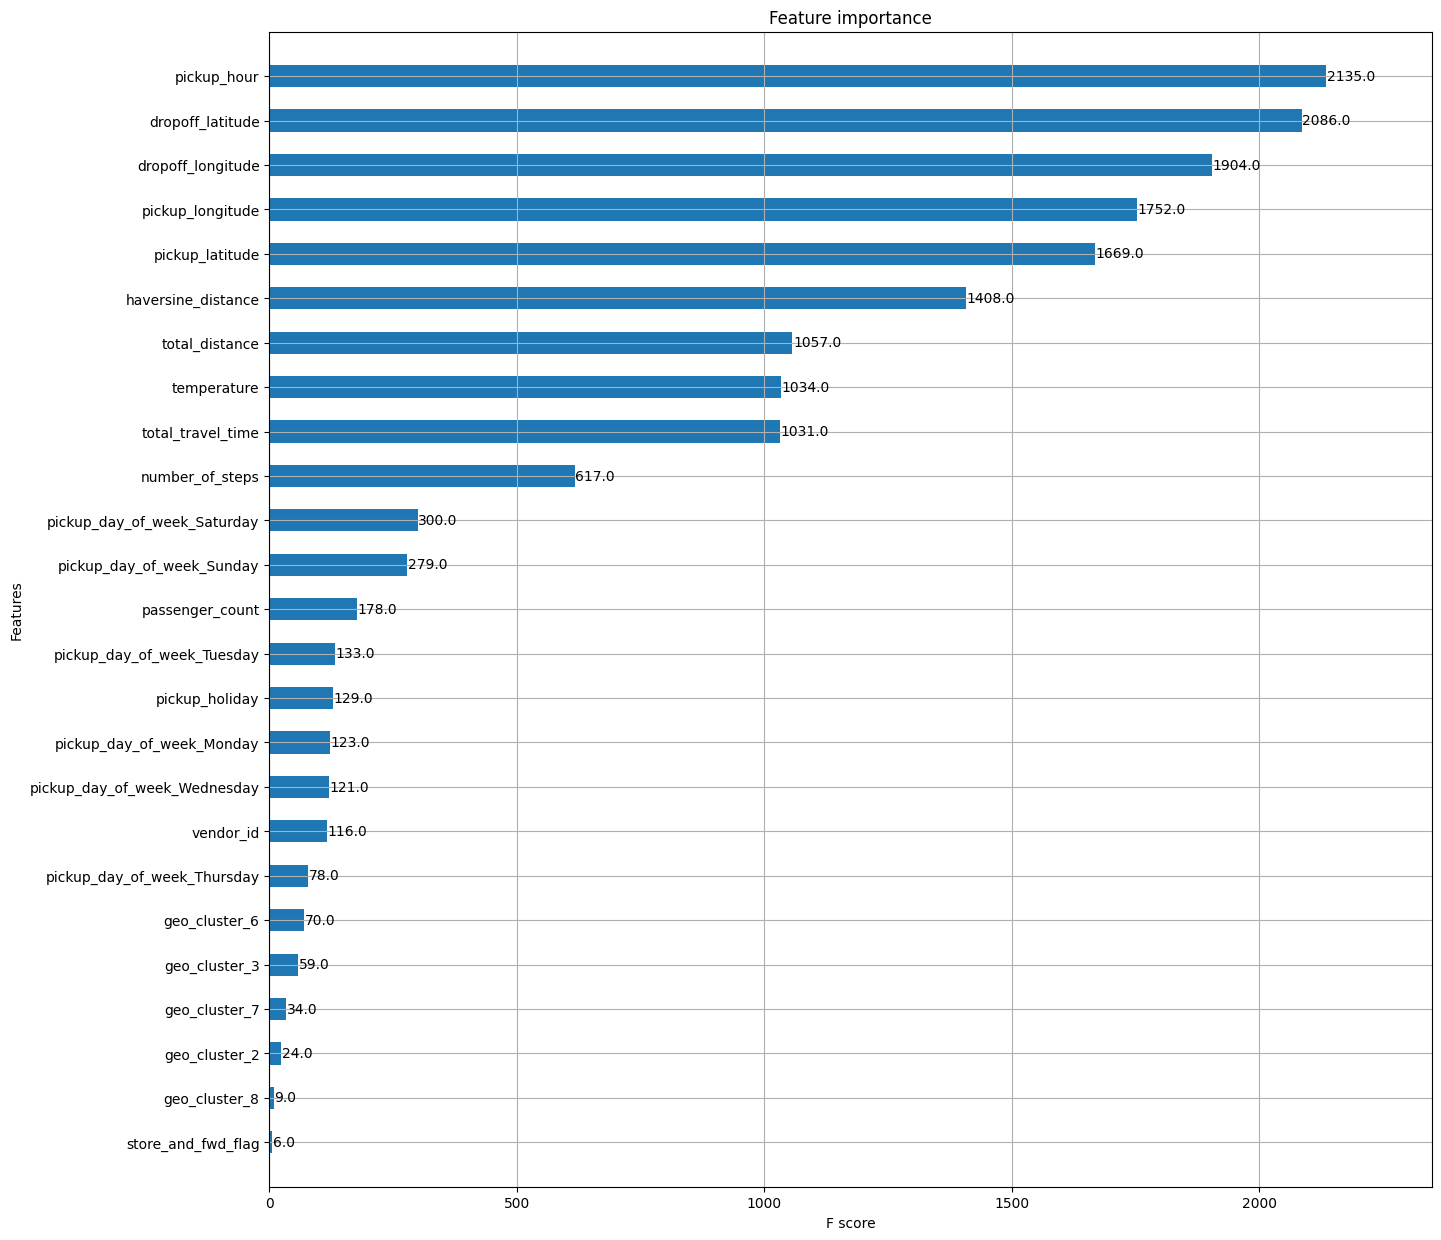

In [128]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(xg_boost, ax = ax, height=0.5);